In [57]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sqlalchemy import create_engine, text
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="ticks")

In [2]:
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


# Q1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [3]:
wego['ADJUSTED_ONTIME_COUNT'].value_counts()

ADJUSTED_ONTIME_COUNT
1    270048
0     80281
Name: count, dtype: int64

In [4]:
(wego['ADJUSTED_ONTIME_COUNT'].sum()/350329)*100

77.08411236295025

# Overall on-time performance = 77.08%

In [53]:
wego['HDWY_PCT'] = wego['HDWY_DEV']/wego['SCHEDULED_HDWY']

In [54]:
wego['HDWY_PCT']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
350324    0.175556
350325         NaN
350326    0.062222
350327    0.583333
350328         NaN
Name: HDWY_PCT, Length: 350329, dtype: float64

In [55]:
wego['BUNCHING'] = (wego['HDWY_PCT'] < -0.5)
wego['GAPPING'] = wego['HDWY_PCT'] > 0.5
wego['ACCEPTED'] = (wego['HDWY_PCT'] >= -0.5) & (wego['HDWY_PCT'] <= 0.5)

In [83]:
headway = wego[['ROUTE_ABBR','HDWY_DEV', 'SCHEDULED_HDWY', 'HDWY_PCT', 'ACCEPTED', 'BUNCHING', 'GAPPING']].dropna()
headway

,ROUTE_ABBR,HDWY_DEV,SCHEDULED_HDWY,HDWY_PCT,ACCEPTED,BUNCHING,GAPPING
7,22,2.666666,35.0,0.076190,True,False,False
8,22,1.966666,35.0,0.056190,True,False,False
9,22,-0.483334,15.0,-0.032222,True,False,False
11,22,-2.166667,15.0,-0.144444,True,False,False
12,22,-3.883334,15.0,-0.258889,True,False,False
...,...,...,...,...,...,...,...
350320,7,6.716666,30.0,0.223889,True,False,False
350323,7,4.916666,30.0,0.163889,True,False,False
350324,7,5.266666,30.0,0.175556,True,False,False
350326,7,1.866666,30.0,0.062222,True,False,False


In [84]:
headway["ACCEPTED"] = headway["ACCEPTED"].astype(int)
headway["BUNCHING"] = headway["BUNCHING"].astype(int)
headway["GAPPING"] = headway["GAPPING"].astype(int)
headway

,ROUTE_ABBR,HDWY_DEV,SCHEDULED_HDWY,HDWY_PCT,ACCEPTED,BUNCHING,GAPPING
7,22,2.666666,35.0,0.076190,1,0,0
8,22,1.966666,35.0,0.056190,1,0,0
9,22,-0.483334,15.0,-0.032222,1,0,0
11,22,-2.166667,15.0,-0.144444,1,0,0
12,22,-3.883334,15.0,-0.258889,1,0,0
...,...,...,...,...,...,...,...
350320,7,6.716666,30.0,0.223889,1,0,0
350323,7,4.916666,30.0,0.163889,1,0,0
350324,7,5.266666,30.0,0.175556,1,0,0
350326,7,1.866666,30.0,0.062222,1,0,0


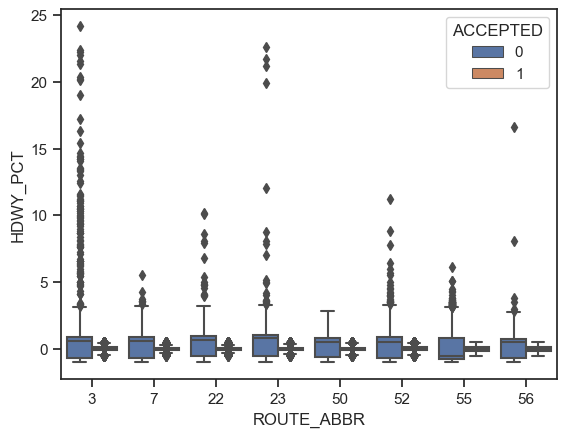

In [89]:
sns.boxplot(data=headway, x='ROUTE_ABBR', y='HDWY_PCT', hue="ACCEPTED")
plt.show()

In [98]:
route_headway = wego[["ROUTE_DIRECTION_NAME", "ROUTE_ABBR", "BUNCHING", "GAPPING", "ACCEPTED"]].groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).agg('sum')
route_headway = route_headway.reset_index()
route_headway

,ROUTE_ABBR,ROUTE_DIRECTION_NAME,BUNCHING,GAPPING,ACCEPTED
0,3,FROM DOWNTOWN,1443,1829,15010
1,3,TO DOWNTOWN,736,1115,16450
2,7,FROM DOWNTOWN,287,377,5221
3,7,TO DOWNTOWN,176,238,5279
4,22,FROM DOWNTOWN,212,489,8246
5,22,TO DOWNTOWN,85,250,7725
6,23,FROM DOWNTOWN,486,1157,15140
7,23,TO DOWNTOWN,244,789,10662
8,50,FROM DOWNTOWN,659,790,15836
9,50,TO DOWNTOWN,397,618,16293


ValueError: Could not interpret input 'HDWY_PCT'

In [5]:
#wego['ADHERENCE'].apply(['min', 'max', 'mean', 'median'])

min      -948.533333
max        88.383333
mean       -3.188796
median     -2.000000
Name: ADHERENCE, dtype: float64

In [6]:
#wego['HDWY_DEV'].apply(['min', 'max', 'mean', 'median'])

min       -64.000000
max       565.433333
mean        0.518081
median      0.033333
Name: HDWY_DEV, dtype: float64

In [7]:
# Calculate Adherence mean and standard deviation
#ad_mean = wego['ADHERENCE'].mean()
#ad_std = np.std(wego['ADHERENCE'])

[Text(0.5, 1.0, 'Adherence Distribution Excluding Outliers'),
 Text(0.5, 0, 'Adherence')]

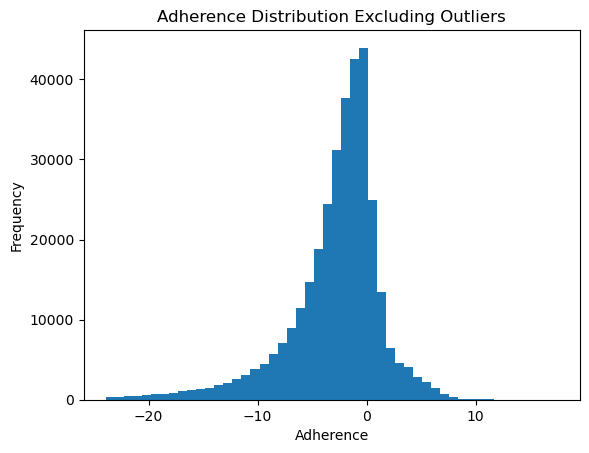

In [8]:
ax = (
    wego[wego['ADHERENCE'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['ADHERENCE']
    .plot(kind='hist',
          bins=50)
)

ax.set(
    title='Adherence Distribution Excluding Outliers',
    xlabel='Adherence'
    )

In [74]:
# Calculate Headway Deviation mean and standard deviation
hd_mean = headway['HDWY_PCT'].mean()
hd_std = np.std(headway['HDWY_PCT'])

[Text(0.5, 1.0, 'Headway Deviation Distribution Excluding Outliers'),
 Text(0.5, 0, 'Headway Deviation')]

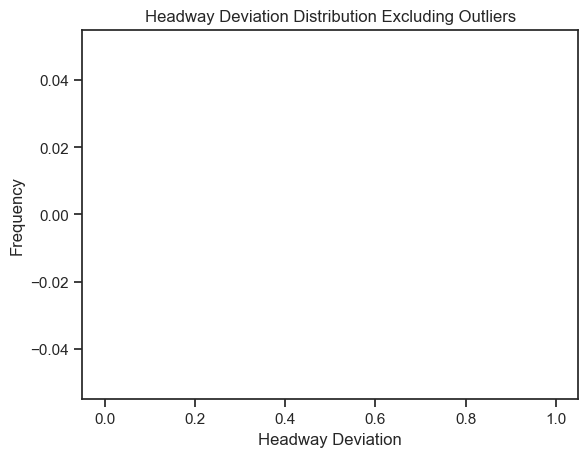

In [76]:
ax= (
    headway[headway['HDWY_PCT'].between(hd_mean - hd_std*3, 
                                  hd_mean + hd_std*3, 
                                  inclusive='both')]
    ['HDWY_PCT']
    .plot(kind='hist', bins=50)
)

ax.set(
    title='Headway Deviation Distribution Excluding Outliers',
    xlabel='Headway Deviation'
    )

# Q2. How does direction of travel, route, or location affect the headway and on-time performance?

In [11]:
wego.groupby('ROUTE_DIRECTION_NAME')[['ADHERENCE', 'HDWY_DEV']].describe()

ADHERENCE                                            \
                         count      mean       std         min       25%   
ROUTE_DIRECTION_NAME                                                       
FROM DOWNTOWN         179306.0 -3.960287  7.234279 -948.533333 -5.466666   
TO DOWNTOWN           159555.0 -2.321804  6.391098 -618.166666 -3.666666   

                                                     HDWY_DEV            \
                           50%       75%        max     count      mean   
ROUTE_DIRECTION_NAME                                                      
FROM DOWNTOWN        -2.516666 -0.633333  76.766666  141392.0  0.579990   
TO DOWNTOWN          -1.500000 -0.100000  88.383333  124501.0  0.447773   

                                                                             
                           std        min   25%       50%   75%         max  
ROUTE_DIRECTION_NAME                                                         
FROM DOWNTOWN         7.773842 -55.533334 -2.65  0.033333  2.85  565.433333  
TO DOWNTOWN           6.395390 -64.000000 -2.00  0.033333  2.15  543.833333

# Inbound has slightly better adherence and headway deviation.

In [12]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE', 'HDWY_DEV']].describe()

ADHERENCE                                                      \
               count      mean       std         min       25%       50%   
ROUTE_ABBR                                                                 
3            45488.0 -3.761491  5.415910 -133.250000 -5.350000 -2.566666   
7            17267.0 -3.346555  6.669753  -87.716666 -4.916666 -2.116666   
22           25188.0 -1.138107  6.391798 -675.000000 -2.950000 -0.933333   
23           39653.0 -1.760110  7.680491 -618.166666 -3.116666 -1.316666   
50           42629.0 -2.505022  6.159666 -489.316666 -3.883333 -1.800000   
52           49327.0 -3.971342  8.721732 -948.533333 -5.016666 -2.066666   
55           60359.0 -4.823302  7.535092 -375.233333 -6.583333 -2.883333   
56           58950.0 -2.703988  4.931009 -322.783333 -4.300000 -1.900000   

                                HDWY_DEV                                  \
                 75%        max    count      mean        std        min   
ROUTE_ABBR                                                                 
3          -0.766666  33.750000  36583.0  0.580907   6.203530 -64.000000   
7          -0.616666  88.383333  11578.0  0.336808   5.909983 -30.433334   
22          0.816666  24.733333  17007.0  0.955867  10.248444 -43.650000   
23          0.033333  33.633333  28478.0  1.053563   9.881327 -32.116667   
50         -0.300000  22.350000  34593.0  0.212376   4.760558 -33.250000   
52         -0.400000  30.200000  39887.0  0.974776   9.185015 -55.533334   
55         -0.850000  40.250000  49432.0  0.261038   6.364978 -29.933334   
56         -0.283333  39.916666  48335.0  0.149213   4.714435 -27.266667   

                                                      
                 25%       50%       75%         max  
ROUTE_ABBR                                            
3          -2.450000  0.116666  2.800000   76.866666  
7          -1.983334  0.033333  2.133333   50.250000  
22         -1.966667  0.050000  2.200000  508.700000  
23         -1.733334  0.066666  2.066666  565.433333  
50         -2.083334  0.033333  2.183333   54.283333  
52         -2.450000  0.083333  2.783333  472.366666  
55         -3.150000 -0.033334  2.983333  102.000000  
56         -2.333334  0.000000  2.383333  166.000000

In [13]:
wego.groupby('BLOCK_ABBR')['ADHERENCE'].mean().abs().sort_values(ascending=True)

BLOCK_ABBR
8604     0.281250
2301     0.353140
2210     0.442440
2211     0.529404
8401     0.603704
          ...    
5218     7.901945
5513     8.414195
5590     9.226351
9975    15.559701
9950    32.378019
Name: ADHERENCE, Length: 102, dtype: float64

In [14]:
wego.groupby('BLOCK_ABBR')['HDWY_DEV'].mean().abs().sort_values()

BLOCK_ABBR
5205    0.046474
5603    0.058075
5506    0.071138
5600    0.080669
5003    0.094910
          ...   
5690         NaN
8401         NaN
8405         NaN
8601         NaN
9302         NaN
Name: HDWY_DEV, Length: 102, dtype: float64

# Block 8604 has the best ADHERENCE and Block 5690 has the best Headway Deviation.

In [15]:
routedir_headway = wego[["ROUTE_DIRECTION_NAME", "ROUTE_ABBR", "HDWY_DEV", "ADHERENCE"]].groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).mean("HDWY_DEV", "ADHERENCE")

In [16]:
routedir_headway = routedir_headway.reset_index()

In [17]:
routedir_headway.columns

Index(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'HDWY_DEV', 'ADHERENCE'], dtype='object')

In [18]:
routedir_headway

,ROUTE_ABBR,ROUTE_DIRECTION_NAME,HDWY_DEV,ADHERENCE
0,3,FROM DOWNTOWN,0.636069,-4.831550
1,3,TO DOWNTOWN,0.525802,-2.689360
2,7,FROM DOWNTOWN,0.379082,-4.028927
3,7,TO DOWNTOWN,0.293108,-2.599183
4,22,FROM DOWNTOWN,1.088609,-2.179503
5,22,TO DOWNTOWN,0.808517,-0.041538
6,23,FROM DOWNTOWN,1.063912,-2.295042
7,23,TO DOWNTOWN,1.038711,-0.959462
8,50,FROM DOWNTOWN,0.222529,-2.729163
9,50,TO DOWNTOWN,0.202238,-2.282192


In [19]:
def direction(x):
    return wego[wego['ROUTE_DIRECTION_NAME']==x]

#function to call wego data based on route
def route(x):
    return wego[wego['ROUTE_ABBR']==x]

[Text(0, 0, '3'),
 Text(1, 0, '7'),
 Text(2, 0, '22'),
 Text(3, 0, '23'),
 Text(4, 0, '50'),
 Text(5, 0, '52'),
 Text(6, 0, '55'),
 Text(7, 0, '56')]

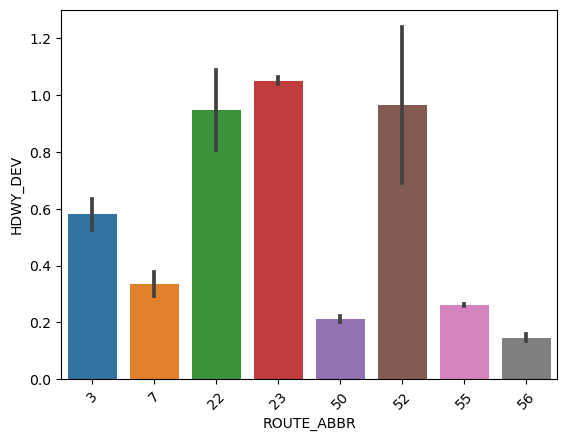

In [20]:
routeplot = sns.barplot(x="ROUTE_ABBR",
           y="HDWY_DEV",
          # hue="ROUTE_DIRECTION_NAME",
           data=routedir_headway)
#rotate labels
routeplot.set_xticklabels(routeplot.get_xticklabels(), rotation=45)

In [25]:
location_headway_adh = wego[["TIME_POINT_ABBR", "ROUTE_ABBR", "HDWY_DEV", "ADHERENCE"]].groupby(['TIME_POINT_ABBR', 'ROUTE_ABBR']).mean("HDWY_DEV", "ADHERENCE")

In [42]:
wego.groupby('TIME_POINT_ABBR')['ADHERENCE'].mean().abs().sort_values(ascending=True)

TIME_POINT_ABBR
MCC5_10     0.328900
MCC4_24     0.382911
MCC4_18     0.810037
HEAD        1.013657
MCC5_2      1.252623
             ...    
DCSCC       7.091481
MCC5_7      9.075463
MCC5_12     9.785042
MCC4_20    13.356229
MCC5_11    37.570714
Name: ADHERENCE, Length: 61, dtype: float64

In [43]:
wego.groupby('TIME_POINT_ABBR')['HDWY_DEV'].mean().abs().sort_values()

TIME_POINT_ABBR
MCC4_18     0.080116
GXMADISO    0.128788
GXFIVEPT    0.133755
GXGRNFLD    0.139439
MCC5_1      0.150845
              ...   
MCC5_11          NaN
MCC5_12          NaN
MCC5_2           NaN
MCC5_6           NaN
MCC5_7           NaN
Name: HDWY_DEV, Length: 61, dtype: float64

In [26]:
location_headway_adh = location_headway_adh.reset_index()

In [27]:
location_headway_adh

,TIME_POINT_ABBR,ROUTE_ABBR,HDWY_DEV,ADHERENCE
0,21BK,7,0.398813,-4.180070
1,25ACLARK,22,0.551163,1.458553
2,28&CHARL,50,0.198635,-2.838419
3,ARTS,55,1.450000,-4.233489
4,BRCJ,3,1.161457,-3.864808
...,...,...,...,...
64,WE31,3,0.522487,-3.945215
65,WHBG,3,0.656069,-4.657638
66,WHBG,50,0.230404,-2.925921
67,WMRT,52,0.419229,-3.715836


In [31]:
def location(x):
    return wego[wego['TIME_POINT_ABBR']==x]

#function to call wego data based on route
#def route(x):
#   return wego[wego['ROUTE_ABBR']==x]

C:\Users\joshh\anaconda3\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\joshh\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


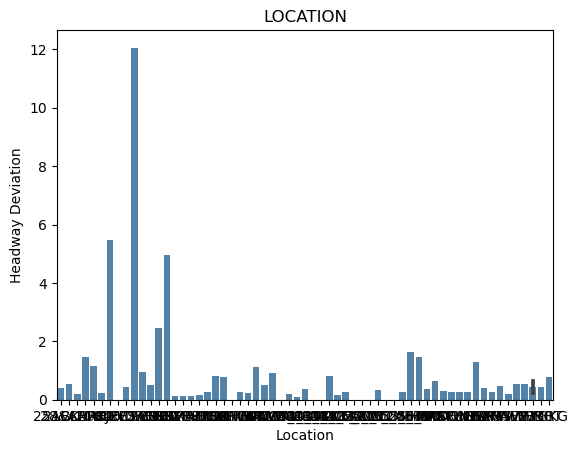

In [38]:
ax = sns.barplot(x='TIME_POINT_ABBR', y='HDWY_DEV', 
                 data = location_headway_adh, 
                 color='steelblue')

#specfiy axis labels
ax.set(xlabel='Location',
       ylabel='Headway Deviation',
       title='LOCATION')

#display barplot
plt.show()

In [21]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE', 'HDWY_DEV']].describe()

ADHERENCE                                                      \
                    count      mean       std         min       25%       50%   
TIME_POINT_ABBR                                                                 
21BK               5895.0 -4.180070  6.608970  -59.600000 -5.850000 -2.966666   
25ACLARK           2391.0  1.458553  3.833998  -48.400000 -0.608333  0.850000   
28&CHARL           7036.0 -2.838419  3.723730  -91.416666 -4.000000 -2.016666   
ARTS                107.0 -4.233489  4.229100  -18.316666 -6.458333 -3.316666   
BRCJ               4009.0 -3.864808  5.543253 -131.900000 -5.083333 -2.433333   
...                   ...       ...       ...         ...       ...       ...   
WE23               8291.0 -3.929729  5.056735 -118.883333 -5.683333 -2.816666   
WE31               8297.0 -3.945215  5.138368 -119.383333 -5.616666 -2.750000   
WHBG              11354.0 -3.586182  4.941825  -91.883333 -4.900000 -2.416666   
WMRT               8648.0 -3.715836  6.871819 -133.950000 -4.500000 -1.666666   
YGKG               2021.0 -3.588174  4.792730  -29.083333 -5.716666 -2.333333   

                                     HDWY_DEV                                 \
                      75%        max    count      mean       std        min   
TIME_POINT_ABBR                                                                
21BK            -0.883333  85.666666   5773.0  0.398813  6.575288 -30.433334   
25ACLARK         4.475000  24.233333   1132.0  0.551163  5.783526 -21.433334   
28&CHARL        -0.550000   8.933333   6914.0  0.198635  4.786516 -25.250000   
ARTS            -2.200000  11.450000     16.0  1.450000  3.262418   0.050000   
BRCJ            -0.850000   9.416666   3887.0  1.161457  8.646200 -33.600000   
...                   ...        ...      ...       ...       ...        ...   
WE23            -0.824999  27.283333   8169.0  0.531195  5.935266 -27.700000   
WE31            -0.733333  27.900000   8175.0  0.522487  5.891651 -28.833334   
WHBG            -0.666666  27.216666   9022.0  0.330427  5.426289 -64.000000   
WMRT            -0.362499  20.616666   8526.0  0.419229  6.294365 -30.666667   
YGKG            -0.383333   8.133333   1140.0  0.782324  9.052621 -23.316667   

                                                           
                      25%       50%       75%         max  
TIME_POINT_ABBR                                            
21BK            -2.683334  0.033333  2.766666   50.250000  
25ACLARK        -1.200000 -0.066667  1.200000  125.066666  
28&CHARL        -2.133334  0.066666  2.283333   36.600000  
ARTS             0.133333  0.166666  0.287500   11.416666  
BRCJ            -2.383334  0.116666  2.774999   76.866666  
...                   ...       ...       ...         ...  
WE23            -2.766667  0.166666  3.050000   54.766666  
WE31            -2.666667  0.083333  3.083333   56.150000  
WHBG            -2.116667  0.050000  2.329166   69.916666  
WMRT            -2.416667  0.000000  2.495833   80.083333  
YGKG            -2.116667  0.000000  2.425000  181.816666  

[61 rows x 16 columns]

# Q3. How does time of day or day of week affect headway and on-time performance?

# Q4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

# Q5. Is there any relationship between lateness (ADHERENCE) and headway deviation?